In [ ]:
# ..... genes up/down-regulated in chicken and turtle ..... #

In [15]:
library(Seurat)
library(SingleCellExperiment)
library(MetaNeighbor)
library(dplyr)

In [3]:
# get orthologs
om = read.delim('turtle/turtle_chicken_orthologs_biomart.txt', sep = '\t')
om <- om[which(om[,1]!='' & om[,2]!='' & !is.na(om[,5]) & om[,5]==1 & om[,4]=='ortholog_one2one'),]
dim(om)
om[1,]

[1] 11275     5

Gene.name Chicken.gene.name Last.common.ancestor.with.Chicken
10 ND2       ND2               Archelosauria                    
   Chicken.homology.type Chicken.orthology.confidence..0.low..1.high.
10 ortholog_one2one      1

In [4]:
# load data
get_seurat_obj <- function(currstage1, path0){
    
    sc1 = readRDS(paste0(path0, '/', currstage1, '_integrated_cca.rds'))

    df1 = read.delim(paste0(path0, '/', currstage1, '_Knight-Schrijver_celltypes.csv'), sep = ',')
    ids = match(rownames(sc1@meta.data), df1$barcode)
    sc1$class = df1$class[ids]
    sc1$celltype = df1$final_celltype[ids]
    
    # convert only immature_other into subclass labels
    sc1$celltype2 = sc1$class
    sc1$celltype2[sc1$class=='Immature_other'] <- sc1$celltype[sc1$class=='Immature_other']
#     sc1$cluster = df1$cluster[ids]

    sc1 <- sc1[,!is.na(sc1$celltype) & sc1$celltype!='unassigned']
    
    # remove cell types with <50 cells across all samples combined
    sc1 <- sc1[,!(sc1$celltype2 %in% names(which(table(sc1$celltype2)<50)))]
    sc1$species = path0
    return(sc1)
}

In [5]:
# load individual sample files
stage1 = 'stage14'
sce1 = get_seurat_obj(stage1, 'turtle')
stage2 = 'stage17'
sce2 = get_seurat_obj(stage2, 'turtle')
stage3 = 'stage21'
sce3 = get_seurat_obj(stage3, 'turtle')

In [6]:
# load individual sample files
stage1 = 'stage23'
sce4 = get_seurat_obj(stage1, 'chicken')
sce4$stage = stage1
stage2 = 'stage28'
sce5 = get_seurat_obj(stage2, 'chicken')
sce5$stage = stage2
stage3 = 'stage32'
sce6 = get_seurat_obj(stage3, 'chicken')
sce6$stage = stage3

In [9]:
# get metadata
cols = c('species', 'stage', 'sample', 'class', 'celltype2')
mtd1 = rbind(sce1@meta.data[,cols], sce2@meta.data[,cols], sce3@meta.data[,cols])
mtd2 = rbind(sce4@meta.data[,cols], sce5@meta.data[,cols], sce6@meta.data[,cols])

In [10]:
# get counts matrices for each species
tmat = cbind(sce1@assays$RNA@counts, sce2@assays$RNA@counts, sce3@assays$RNA@counts)
cmat = cbind(sce4@assays$RNA@counts, sce5@assays$RNA@counts, sce6@assays$RNA@counts)

In [11]:
# rename turtle data gene names
rownames(tmat) <- om[match(rownames(tmat), om[,1]),2]
tmat <- tmat[!is.na(rownames(tmat)),]

In [12]:
# subset to common orthologs
common_genes = intersect(rownames(tmat), rownames(cmat))
tmat <- tmat[common_genes,]
cmat <- cmat[common_genes,]

In [13]:
# make SCE object
sce = SingleCellExperiment(list(counts = cbind(tmat, cmat)),
                           colData = DataFrame(rbind(mtd1, mtd2)))
sce$species_stage = paste0(sce$species, '-', sce$stage)
sce

class: SingleCellExperiment 
dim: 10477 149067 
metadata(0):
assays(1): counts
rownames(10477): OTX2 EXOC5 ... RNF152 CDH20
rowData names(0):
colnames(149067): Stage_14_sample4_AAACCCACAATGAACA-1
  Stage_14_sample4_AAACCCACACGACAAG-1 ...
  stage32_sample12_TTTGTTGGTAGACGGT-1
  stage32_sample12_TTTGTTGGTGCTCGTG-1
colData names(6): species stage ... celltype2 species_stage
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [18]:
# go groups
go = read.delim('/data/CoCoCoNet/gene2go/chicken_gene2go.csv', sep = ' ')
ginfo = read.delim('/data/CoCoCoNet/geneInfo/chicken_info.csv', sep = ',')
ginfo[1,]

go$symbol = ginfo$GeneSymbol[match(go$NetworkIDs, ginfo$NetworkIDs)]
go <- go[!is.na(go$symbol),]
head(go)

EntrezID EnsemblID          GeneSymbol LocusTag Synonyms dbXrefs Chromosome
1 776458   ENSGALG00000045540 CLC2DL5    NA       NA       |NA|    1         
  Type           UniProtID UniProtID2 OrthoID       NetworkIDs        
1 protein-coding NA        NA         9031_0:004484 ENSGALG00000045540

NetworkIDs         GO_term    symbol  
1 ENSGALG00000032366 GO:0000002 MEF2A   
2 ENSGALG00000009228 GO:0000002 PARP1   
3 ENSGALG00000010636 GO:0000002 PRIMPOL 
4 ENSGALG00000004037 GO:0000002 DNA2    
5 ENSGALG00000005283 GO:0000002 SLC25A36
6 ENSGALG00000007150 GO:0000002 OPA1

In [43]:
go_groups = unique(go$GO_term)
go_sets = list()
ctr = 0
for(ii in 1:length(go_groups)){
    num_genes = sum(go$GO_term==go_groups[ii])
    if(num_genes>=5 & num_genes<=200){
        ctr = ctr + 1
        go_sets[[ctr]] = unique(go$symbol[go$GO_term==go_groups[ii]])
        names(go_sets)[ctr] = go_groups[ii]
    }
}
save(go_sets, file = 'chicken_GO_sets.Rdata')

In [30]:
unique(sce$species_stage)

[1] "turtle-Stage_14" "turtle-Stage_17" "turtle-Stage_21" "chicken-stage23"
[5] "chicken-stage28" "chicken-stage32"

In [70]:
sce3 = sce[,sce$species_stage %in% c('turtle-Stage_21')]  #'turtle-Stage_14'

In [67]:
sce2 = sce[,sce$species_stage %in% c('chicken-stage32')]  #'turtle-Stage_14'

In [46]:
load('useful_GO_terms.Rdata')
use_go = gse$GO_term[gse$adj_pvals<0.05]

In [45]:
go_sets2 = go_sets
go_sets2 <- go_sets2[names(go_sets2) %in% use_go]  # run with smaller no. first

In [ ]:
# get GO set AUROC - cross-species
aurocs = MetaNeighbor(dat = sce2,
                      experiment_labels = sce2$species_stage,
                      celltype_labels = sce2$celltype2,
                      genesets = go_sets2,
                      fast_version = TRUE, bplot = FALSE, batch_size = 50)
write.table(aurocs, "chicken_turtle_stage3_GO_aurocs.txt")

In [ ]:
# get GO set AUROC - indiv species
aurocs = MetaNeighbor(dat = sce2,
                      experiment_labels = sce2$sample,
                      celltype_labels = sce2$celltype2,
                      genesets = go_sets2,
                      fast_version = TRUE, bplot = FALSE, batch_size = 50)
write.table(aurocs, "chicken_stage3_GO_aurocs.txt")

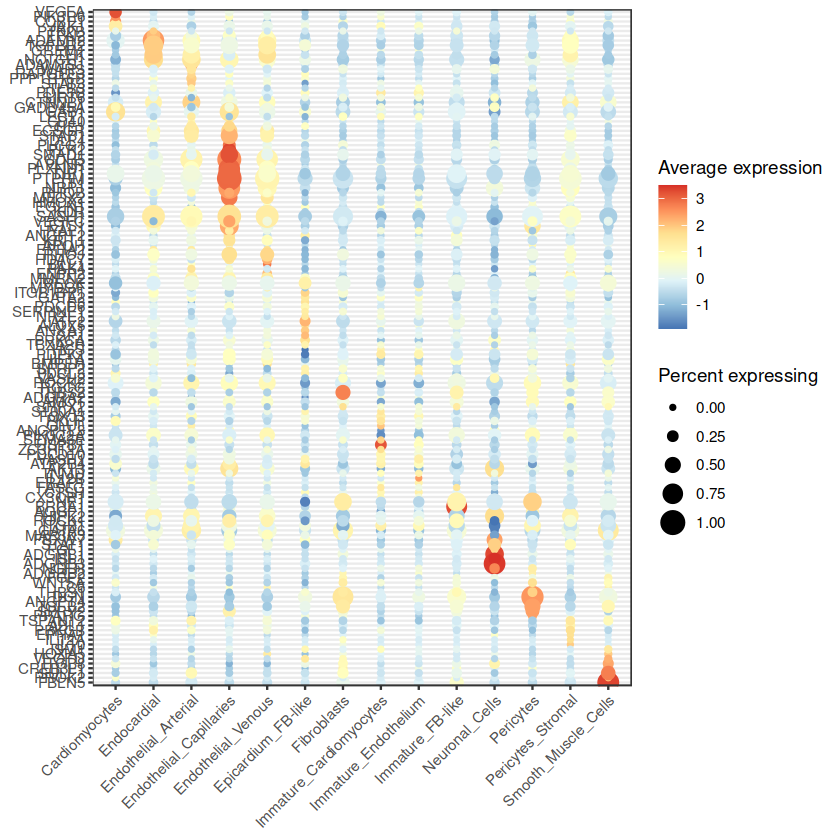

In [72]:
plotDotPlot(dat = sce2,
            experiment_labels = sce2$sample,
            celltype_labels = sce2$celltype2,
            gene_set = go_sets2[['GO:0045765']])

plotDotPlot(dat = sce3,
            experiment_labels = sce3$sample,
            celltype_labels = sce3$celltype2,
            gene_set = go_sets2[['GO:0045765']])